# Рынок заведений общественного питания Москвы

## 1. Читаем и изучаем данные

Импортируем необходимые библиотеки

In [20]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import re
import json
from folium import Map, Marker, Figure
from folium.plugins import MarkerCluster
import plotly.graph_objects as go
import plotly.figure_factory as ff
from collections import Counter
from plotly.subplots import make_subplots

C:\Users\dan25\AppData\Local\Temp\ipykernel_8580\2146812054.py:6: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display



Читаем таблицу

In [2]:
places = pd.read_csv('data/moscow_places.csv')

Выводим 5 первых строк

In [3]:
places.head()

,name,category,address,district,hours,lat,lng,rating,price,avg_bill,middle_avg_bill,middle_coffee_cup,chain,seats
0,WoWфли,кафе,"Москва, улица Дыбенко, 7/1",Северный административный округ,"ежедневно, 10:00–22:00",55.878494,37.478860,5.0,NaN,NaN,NaN,NaN,0,NaN
1,Четыре комнаты,ресторан,"Москва, улица Дыбенко, 36, корп. 1",Северный административный округ,"ежедневно, 10:00–22:00",55.875801,37.484479,4.5,выше среднего,Средний счёт:1500–1600 ₽,1550.0,NaN,0,4.0
2,Хазри,кафе,"Москва, Клязьминская улица, 15",Северный административный округ,"пн-чт 11:00–02:00; пт,сб 11:00–05:00; вс 11:00...",55.889146,37.525901,4.6,средние,Средний счёт:от 1000 ₽,1000.0,NaN,0,45.0
3,Dormouse Coffee Shop,кофейня,"Москва, улица Маршала Федоренко, 12",Северный административный округ,"ежедневно, 09:00–22:00",55.881608,37.488860,5.0,NaN,Цена чашки капучино:155–185 ₽,NaN,170.0,0,NaN
4,Иль Марко,пиццерия,"Москва, Правобережная улица, 1Б",Северный административный округ,"ежедневно, 10:00–22:00",55.881166,37.449357,5.0,средние,Средний счёт:400–600 ₽,500.0,NaN,1,148.0


И выведем основную информацию о таблице

In [4]:
places.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8406 entries, 0 to 8405
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               8406 non-null   object 
 1   category           8406 non-null   object 
 2   address            8406 non-null   object 
 3   district           8406 non-null   object 
 4   hours              7870 non-null   object 
 5   lat                8406 non-null   float64
 6   lng                8406 non-null   float64
 7   rating             8406 non-null   float64
 8   price              3315 non-null   object 
 9   avg_bill           3816 non-null   object 
 10  middle_avg_bill    3149 non-null   float64
 11  middle_coffee_cup  535 non-null    float64
 12  chain              8406 non-null   int64  
 13  seats              4795 non-null   float64
dtypes: float64(6), int64(1), object(7)
memory usage: 919.5+ KB


Посмотрим сколько уникальных заведений у нас есть

In [5]:
places['name'].nunique()

5614

Также стоит посмотреть распределение заведений по районам

Центральный административный округ         2242
Северный административный округ             900
Южный административный округ                892
Северо-Восточный административный округ     891
Западный административный округ             851
Восточный административный округ            798
Юго-Восточный административный округ        714
Юго-Западный административный округ         709
Северо-Западный административный округ      409
Name: district, dtype: int64

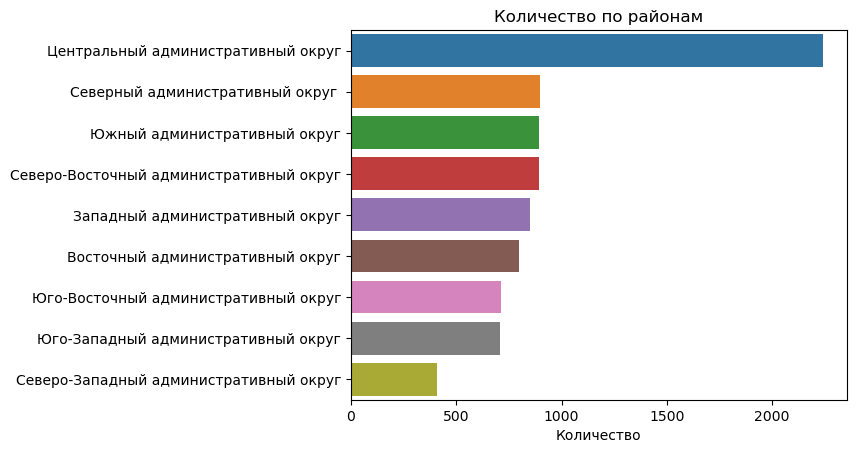

In [6]:
fig, ax = plt.subplots()

okr = ['Центральный административный округ',
       'Северный административный округ ',
       'Южный административный округ',
       'Северо-Восточный административный округ',
       'Западный административный округ',
       'Восточный административный округ',
       'Юго-Восточный административный округ',
       'Юго-Западный административный округ',
       'Северо-Западный административный округ']
sns.barplot(y = okr,x = places['district'].value_counts(), orient='h').set_title('Количество по районам')
ax.set_xlabel('Количество')
places['district'].value_counts()

Самое большое количество заведений находяться в ЦАО. Причем разрыв со вторым местом более чем в 2 раза. На кстати находится САО. ЮАО и СВАО находяться на 3 и 4 месте. И эти трое проктически равны по количеству заведений.

Количество сетевых заведений и не сетевых

0    5201
1    3205
Name: chain, dtype: int64

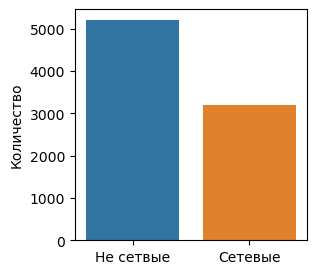

In [7]:
fig, ax = plt.subplots(figsize = (3,3))
sns.barplot(x = ['Не сетвые', 'Сетевые'],y = places['chain'].value_counts())
ax.set_ylabel('Количество')
places['chain'].value_counts()

Заведения которые не являются сетевыми превосходят сетевый более чем в 2 раза 

Также посмотрим распределение по ценовым категориям

средние          2117
выше среднего     564
высокие           478
низкие            156
Name: price, dtype: int64

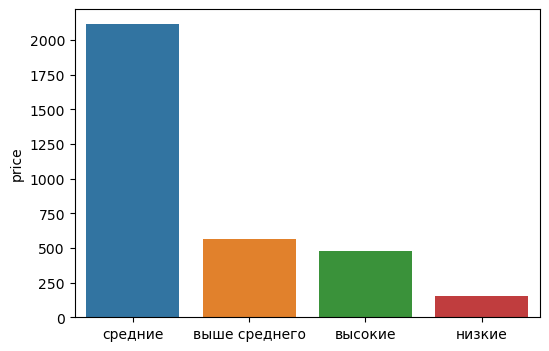

In [8]:
fig, ax = plt.subplots(figsize = (6,4))
poi = ['средние','выше среднего','высокие','низкие']
sns.barplot(x = poi,y = places['price'].value_counts())
places['price'].value_counts()

Средний сегмент сильно впереди 

## 2. Предобработка данных

### Дубликаты

In [9]:
places.duplicated().sum()

0

Полных дупликатов нет. Как мне кажется что из всех столбцов дубликатов не может быть только в столбцах долготы и широты. Проверим 

In [10]:
places[['lat','lng']].duplicated().sum()

34

Дубликаты есть, но их очень мало. Можем их просто удалить

In [11]:
places = places.loc[~places.duplicated(['lat', 'lng'])]

### Пропуски

In [12]:
places.isna().sum().to_frame()

,0
name,0
category,0
address,0
district,0
hours,534
lat,0
lng,0
rating,0
price,5063
avg_bill,4564


Пропуски есть. Первый столбец в котором есть пропуски, это столбец hours (часы работы). В этом столбце не так много пропусков. 

In [13]:
places['price'].value_counts()

средние          2114
выше среднего     561
высокие           478
низкие            156
Name: price, dtype: int64

### Создаем столбец с названиями улиц   

In [14]:
### взял готовый вариант со stackoverflow
words = ['улица','ул','переулок','шоссе','проспект','площадь','проезд',
         'село','аллея','бульвар','набережная','тупик','линия']
str_pat = r".*,\s*\b([^,]*?(?:{})\b[^,]*)[,$]+".format("|".join(words))
places['street'] = places["address"].str.extract(str_pat)

### Создаем стобец с обазначением круглосуточной работы

In [15]:
def is_24(hours):
    if 'ежедневно, круглосуточно' == hours:
        return True
    else:
        return False
places['is_24/7'] = places['hours'].apply(is_24)

## 3. Анализ данных

### Распределение по категориям

кафе               2360
ресторан           2035
кофейня            1412
бар,паб             765
пиццерия            631
быстрое питание     599
столовая            315
булочная            255
Name: category, dtype: int64

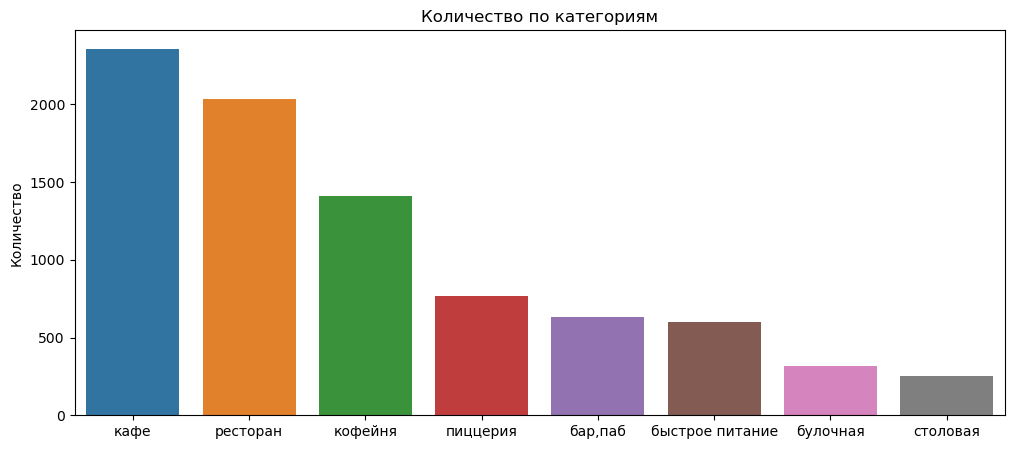

In [16]:
types = places['category'].unique()
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x = types, y = places['category'].value_counts()).set_title('Количество по категориям')
ax.set_ylabel('Количество')
places['category'].value_counts()

Также построим круговую диаграмму

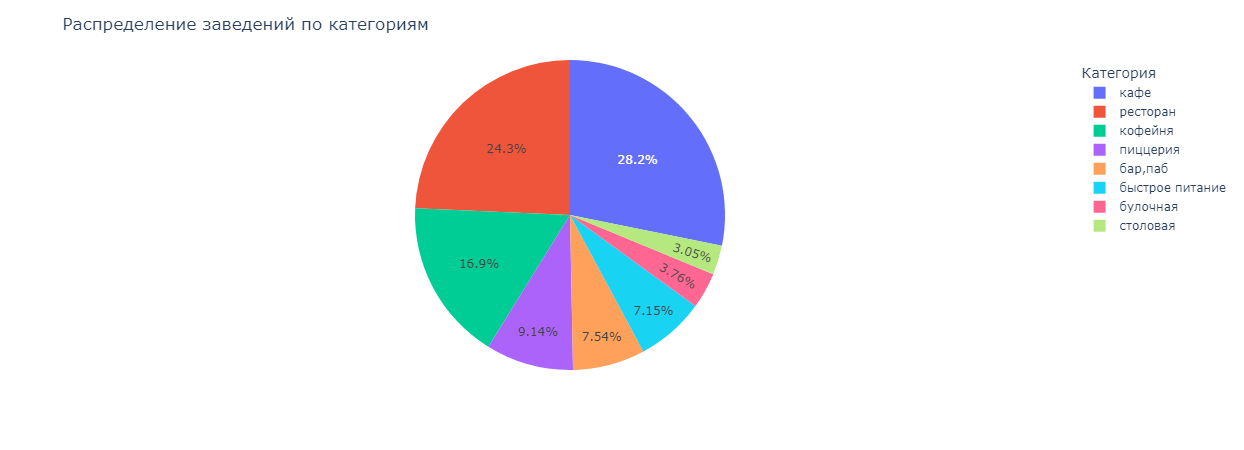

In [49]:
fig = px.pie(values = places['category'].value_counts(), names = types)
fig.update_layout(
    height=450,
    showlegend=True,
    title='Распределение заведений по категориям',
    legend_title='Категория'
)
fig.show()

На первом месте находятся заведения в картегории кафе. На втором распологаются рестораны. А за ними кофейни.  Рестораны не очень сильно отстают от кафе. Всего около 4-х процентов разницы. Третье место уже четь сильнее уступает второмуА далее идет снижение доли 50 процентов

### Количество посадочных мест по категориям

In [44]:
pl_per_cat = places.pivot_table(index = 'category', values = 'seats', aggfunc = ('sum', 'mean', 'median')).reset_index()

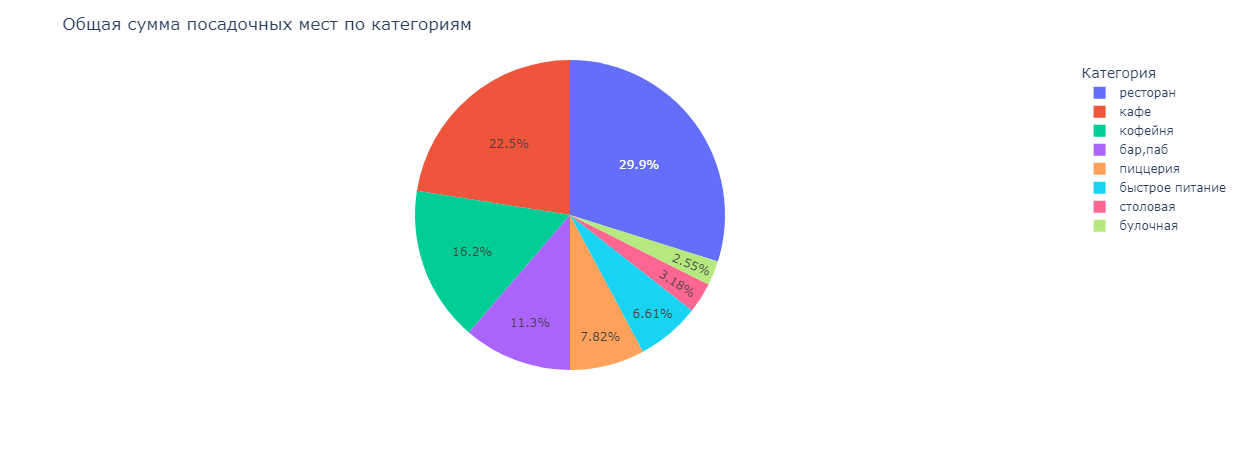

In [47]:
fig = px.pie(values = pl_per_cat['sum'], names = pl_per_cat['category'])
fig.update_layout(
    height=450,
    showlegend=True,
    title='Общая сумма посадочных мест по категориям',
    legend_title='Категория'
)
fig.show()

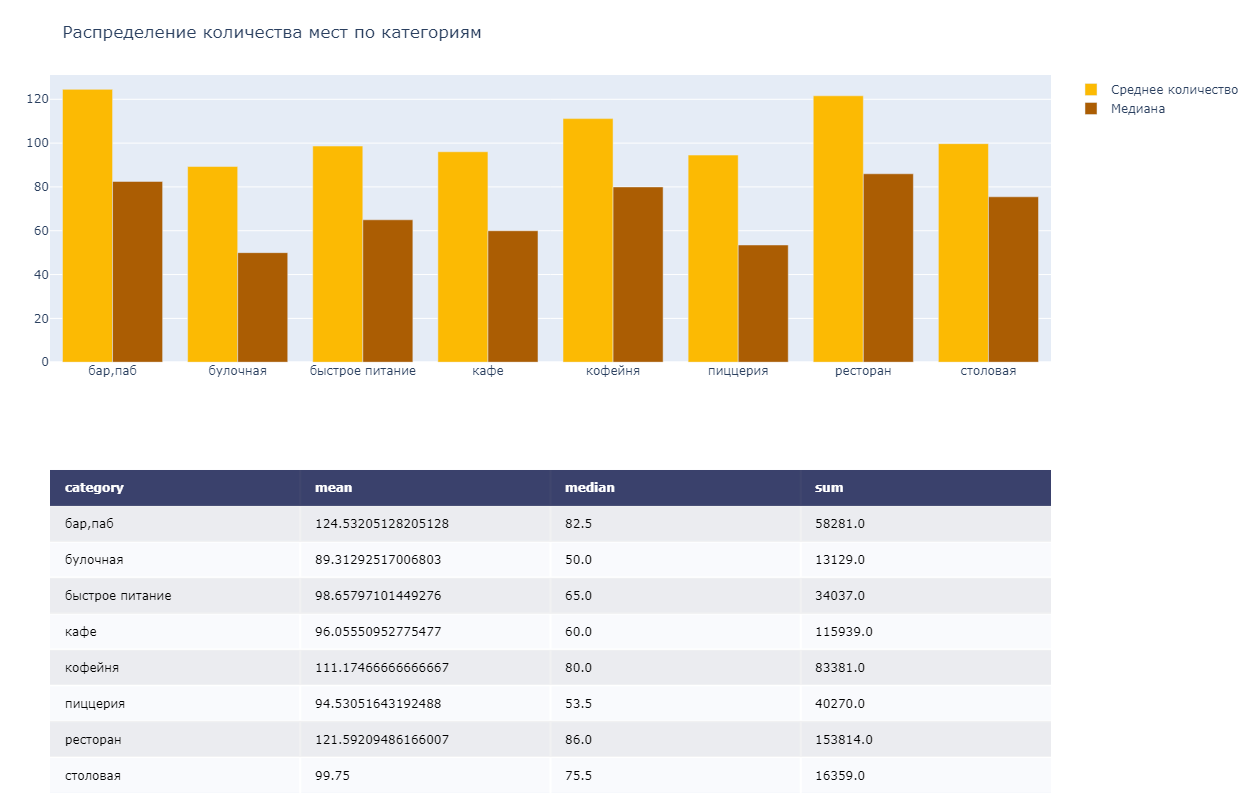

In [45]:
# Initialize a figure with ff.create_table(table_data)
fig = ff.create_table(pl_per_cat, height_constant=60)

# Add graph data
teams = pl_per_cat['category']
mean = pl_per_cat['mean']
median = pl_per_cat['median']

# Make traces for graph
trace1 = go.Bar(x=teams, y=mean, xaxis='x2', yaxis='y2',
                marker=dict(color='#fcba03'),
                name='Среднее количество')

trace2 = go.Bar(x=teams, y=median, xaxis='x2', yaxis='y2',
                marker=dict(color='#ab5d03'),
                name='Медиана')

# Add trace data to figure
fig.add_traces([trace1, trace2])

# initialize xaxis2 and yaxis2
fig['layout']['xaxis2'] = {}
fig['layout']['yaxis2'] = {}

# Edit layout for subplots
fig.layout.yaxis.update({'domain': [0, .45]})
fig.layout.yaxis2.update({'domain': [.6, 1]})

# The graph's yaxis2 MUST BE anchored to the graph's xaxis2 and vice versa
fig.layout.yaxis2.update({'anchor': 'x2'})
fig.layout.xaxis2.update({'anchor': 'y2'})
fig.layout.yaxis2.update({'title': ''})

# Update the margins to add a title and see graph x-labels.
fig.layout.margin.update({'t':75, 'l':50})
fig.layout.update({'title': 'Распределение количества мест по категориям'})

# Update the height because adding a graph vertically will interact with
# the plot height calculated for the table
fig.layout.update({'height':800})

# Plot!
fig.show()

### Соотношение сетевых и не сетевых

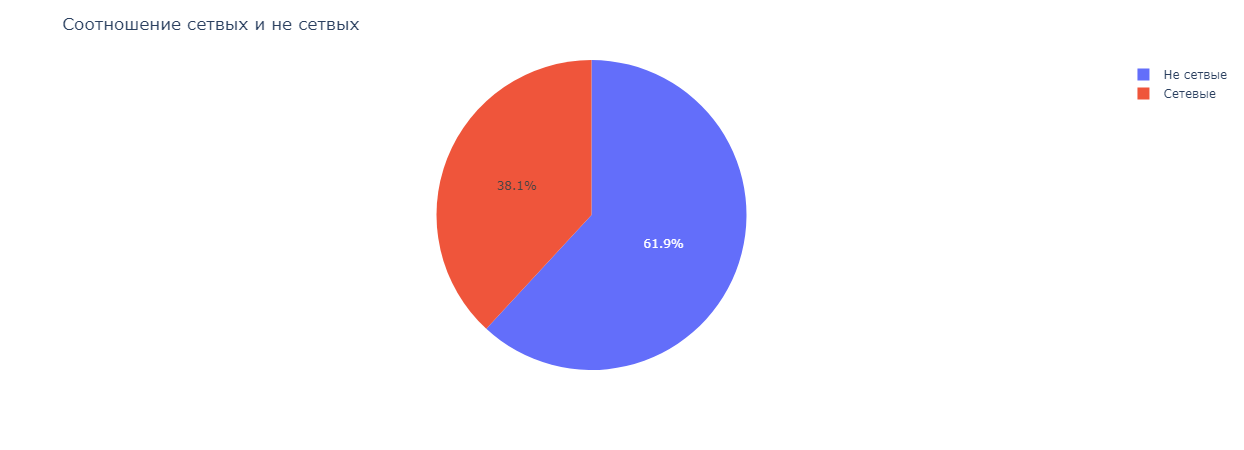

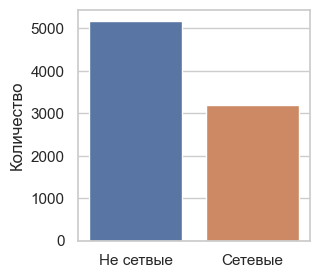

In [54]:
fig = px.pie(values = places['chain'].value_counts(), names = ['Не сетвые', 'Сетевые'])
fig.update_layout(
    height=450,
    showlegend=True,
    title='Соотношение сетвых и не сетвых',
    legend_title=''
)
fig.show()
fig, ax = plt.subplots(figsize = (3,3))
sns.barplot(x = ['Не сетвые', 'Сетевые'],y = places['chain'].value_counts())
ax.set_ylabel('Количество')
plt.show()
#places['chain'].value_counts()

### Какие категории заведений чаще являются сетевыми?

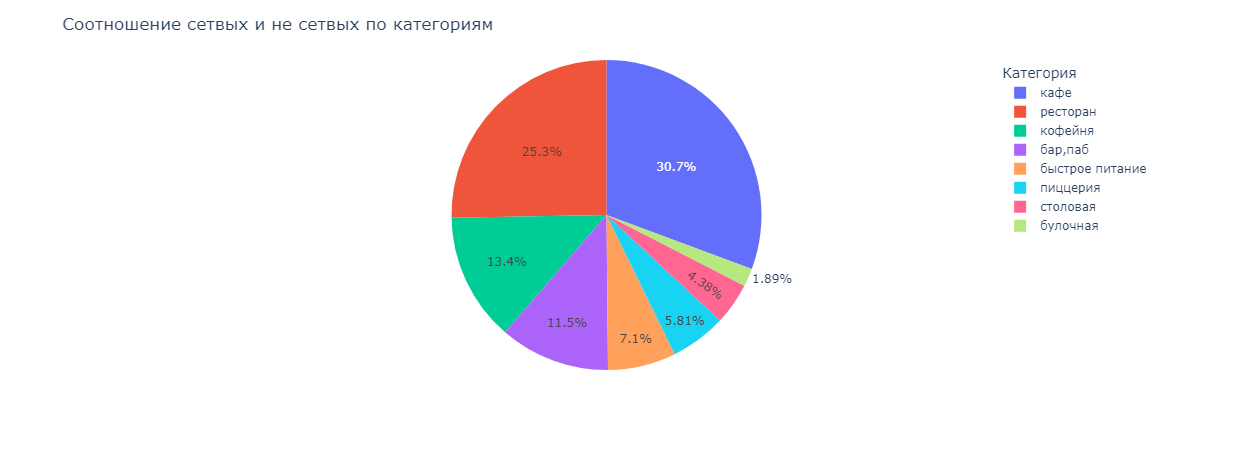

In [67]:
hk = places.pivot_table(index = 'category', columns = 'chain', values = 'name', aggfunc = 'count' ).reset_index()
fig = px.pie(values = hk[0], names = hk['category'])
fig.update_layout(
    height=450,
    showlegend=True,
    title='Соотношение сетвых и не сетвых по категориям',
    legend_title='Категория'
)

### Топ 15 популярных сетей в Москве

### Административные районы 

### Распеределение средних рейтингов

### Фоновая картограмма

### Топ-15 улиц по количеству заведений

### Улицы, на которых находится только один объект общепита. 

###

## 4 Детализируем иследование

### Сколько всего кофеен в датасете?

### В каких районах их больше всего, каковы особенности их расположения?

### Есть ли круглосуточные кофейни?

### Какие у кофеен рейтинги? Как они распределяются по районам?

### На какую стоимость чашки капучино стоит ориентироваться при открытии и почему?

## 5. Подготовка презентации

Презентация: <ссылка на облачное хранилище с презентацией> 